In [1]:
pip install deap

In [2]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'
gdrive_data = '/gdrive/My Drive/my_data/CS454_modelC'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from PIL import Image

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Hyper parameters
params = {
    'input_size': 28,  # image size 1x64x64
    'batch_size': 64,  # batch size
    'pop_size': 100,   # population size
    'nc': 1,  # number of channels
    'nz': 100,  # size of z latent vector
    'ngf': 64,  # size of feature maps in generator
    'ndf': 32,  # size of feature maps in discriminator
    'num_epochs': 1000,  # number of epochs
    'lr': 0.0001,  # learning rate
    'beta1': 0.5,   # beta1 for adam optimizer
    'ngpu': 1,  # number of GPU
    'lambda_gp': 10,  # loss weight for gradient penalty
    'n_critic': 5,
}

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Generator(ngpu, nc, nz, ngf)
# 이 부분에서 체크포인트 위치 설정.
netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_10000.pth', map_location=torch.device('cpu')))

# transform
transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
# data sets and data loader
train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_data, params['batch_size'], shuffle=False)
first_batch = train_data_loader.__iter__().__next__()  # first batch of MNIST data set : torch.Size([64x, 1, 28, 28])
print(first_batch[0][0].shape)  # torch.Size([1, 28, 28])

torch.Size([1, 28, 28])


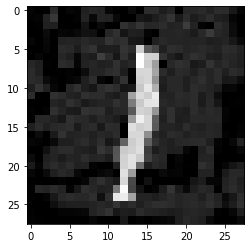

In [5]:
# Input image for defense GAN
# For the test purpose, we will use MNIST data sample first.
'''
fgsm_image_batch = first_batch[0][0]  # torch.Size([1, 28, 28]). This should be fgsm_image later on.

# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image_batch.view(28,28).numpy()

imshow(fgsm_image_batch)
'''


my_image = Image.open(gdrive_data + '/0.15-1to7.jpg')
fgsm_image = TF.to_tensor(my_image)

# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image.view(28,28).numpy()
imshow(fgsm_image)

# Initial population for GA
# initial_population : torch.Size([100, 100, 1, 1]), This has 100 latent vectors z (z is torch.Size([100, 1, 1])).
# for example, initial_population[0] is z_0, initial_population[1] is z_1, ..., initial_population[99] is z_99.
initial_population = torch.FloatTensor(params['pop_size'], params['nz'], 1, 1).normal_(0, 1)

# initial_population를 numpy로 타입 맞춰주기.
initial_population = initial_population.view(100, 100).numpy()

def initIndividual(icls, content):
  return icls(content)

def initPopulation(pcls, ind_init):
  return pcls(ind_init(c) for c in initial_population)

In [0]:
import random
from deap import creator, base, tools, algorithms

# TOCHECK:  will we use algorithm modules?

'''
Fitness : single optimization, minimize ||G(z) - x||^2_2
'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # minimizing the fitness value

toolbox = base.Toolbox()

'''
[HYPERPARAMETERS]
List of Floats: individuals composed of 'IND_SIZE' floating point numbers
IND_SIZE: z의 dimension으로 보면 될듯
POPULATION
CXPB: probability of crossover
MUTPB: probability of mutation
'''
IND_SIZE = 100
POPULATION = 100
CXPB, MUTPB = 0.4, 0.2
GENERATIONS = 100

toolbox.register("attr_float", random.random)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("individual", initIndividual, creator.Individual)
toolbox.register("population", initPopulation, list, toolbox.individual)

In [0]:
def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

def evalFunc(individual):
    individual = torch.from_numpy(individual).view(1, 100, 1, 1)
    return np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2)**2,

In [0]:
'''
Evaluation Function: ||G(z) - x||^2_2 <- use 'np.linalg.norm( , ord=2)**2'
'''
# TODO : need to change mate, mutate, select operator
# can check in here : https://deap.readthedocs.io/en/master/api/tools.html
toolbox.register("evaluate", evalFunc)
# toolbox.register("mate", cxTwoPointCopy)
toolbox.register("mate", tools.cxUniform, indpb=0.1)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [0]:
def main():
    random.seed(777)

    # pop = toolbox.population(n=POPULATION)
    pop = toolbox.population()
    
    print("Start of evolution")

    # Evaluate the entire population
    # print(fitnesses) -> [(84,), (105,), (96,), (104,), (94,),  ... ] 이런식으로 저장됨.
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while min(fits) > 0 and g < GENERATIONS:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        # len(pop) -> 50, len(pop[0]) -> 5
        offspring = toolbox.select(pop, len(pop))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        '''
        they modify those individuals within the toolbox container 
        and we do not need to reassign their results.
        '''

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                size = min(len(child1), len(child2))
                for i in range(5):                    
                  cxpoint = random.randint(2, size - 1)
                  mtpoint = cxpoint - 1
                  # cxpoint -1 위치 : mutate
                  beta = random.random()
                  child1[mtpoint] = child1[mtpoint] - beta*(child1[mtpoint] - child2[mtpoint])
                  child2[mtpoint] = child1[mtpoint] + beta*(child1[mtpoint] - child2[mtpoint])

                  # crossover : one point crossover (temporary crossover algorithm)
                  # child1[cxpoint:], child2[cxpoint:] = child2[cxpoint:], child1[cxpoint:]
                del child1.fitness.values
                del child2.fitness.values
        
        
        # TODO: want p_new1 = p_m - beta(p_m - p_d), p_new2 = p_m + beta(p_m - p_d)
        # want to customize mutation method... there is no proper mutation operator in deap.tools...
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        if g%5 == 0:
          best_ind = tools.selBest(pop, 1)[0]
          tmp_z = torch.from_numpy(best_ind).view(1, 100, 1, 1)
          gen_img = netG(tmp_z)
          imshow(gen_img.detach())

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)


    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    print(best_ind.fitness.values)
    return best_ind
# main()

Start of evolution
-- Generation 1 --
  Min 15.812381870637182
  Max 45.1640498226991
  Avg 29.041286516254758
  Std 5.930039354402692
-- Generation 2 --
  Min 10.806641408187772
  Max 44.90140363627893
  Avg 24.67060730372196
  Std 5.600656309829485
-- Generation 3 --
  Min 10.806641408187772
  Max 40.70584957040046
  Avg 21.658853511745647
  Std 5.303057968050745
-- Generation 4 --
  Min 10.505825454028127
  Max 35.156613454390936
  Avg 18.536074943851574
  Std 5.087854769316065
-- Generation 5 --


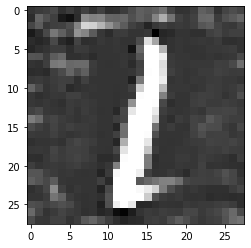

  Min 10.279849179071846
  Max 32.06708055484364
  Avg 15.82966435334852
  Std 4.438152542031806
-- Generation 6 --
  Min 9.242927635568776
  Max 26.476687385639025
  Avg 14.030479215651786
  Std 3.1975869707158022
-- Generation 7 --
  Min 9.242927635568776
  Max 23.650094589742366
  Avg 12.973092037504548
  Std 3.1189111220404846
-- Generation 8 --
  Min 8.79145070402052
  Max 26.926415156741314
  Avg 11.608049445295753
  Std 2.50944015135191
-- Generation 9 --
  Min 7.76480268932778
  Max 21.586103833696143
  Avg 10.98876074794736
  Std 2.020593258391492
-- Generation 10 --


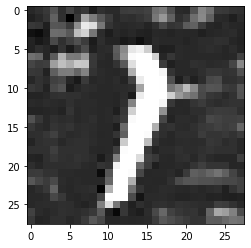

  Min 7.76480268932778
  Max 24.818308275500613
  Avg 10.682339065421882
  Std 2.4665698891266143
-- Generation 11 --
  Min 6.926732332115591
  Max 26.22855601214019
  Avg 10.856032464307466
  Std 3.1622548608877157
-- Generation 12 --
  Min 7.481272999179112
  Max 28.196529834859575
  Avg 11.23760259175155
  Std 4.327602843682374
-- Generation 13 --
  Min 7.481272999179112
  Max 29.276627421955936
  Avg 10.6836489484302
  Std 3.67973553411225
-- Generation 14 --
  Min 7.481272999179112
  Max 31.64662806848378
  Avg 11.077664749206415
  Std 4.631729894908159
-- Generation 15 --


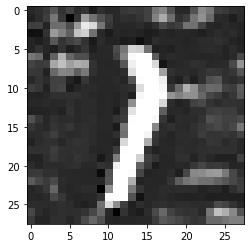

  Min 7.481272999179112
  Max 33.640654910414014
  Avg 10.744397895844752
  Std 4.653211940789669
-- Generation 16 --
  Min 6.804354362910999
  Max 32.895395244064275
  Avg 11.350332588301264
  Std 5.3071244096422605
-- Generation 17 --
  Min 6.804354362910999
  Max 32.07988089401647
  Avg 10.670645495281054
  Std 4.767669805570548
-- Generation 18 --
  Min 6.804354362910999
  Max 26.70055795276221
  Avg 10.274616852410368
  Std 4.3711969841554
-- Generation 19 --
  Min 6.804354362910999
  Max 26.682638255424763
  Avg 9.753180706799355
  Std 4.2257748191780395
-- Generation 20 --


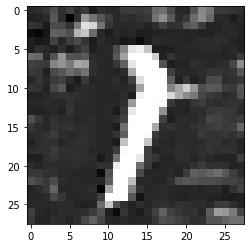

  Min 6.695182653691575
  Max 30.060881534649525
  Avg 8.748810512163445
  Std 3.492080802145377
-- Generation 21 --
  Min 6.695182653691575
  Max 25.321053445992447
  Avg 8.237944885192602
  Std 2.97152938217749
-- Generation 22 --
  Min 6.639424521211424
  Max 23.153185236566287
  Avg 8.291041897777037
  Std 3.2241957768011997
-- Generation 23 --
  Min 6.639424521211424
  Max 25.824565071379993
  Avg 8.740828277583898
  Std 4.233995589508919
-- Generation 24 --
  Min 6.623801352309101
  Max 28.77668407640249
  Avg 8.221800711149667
  Std 3.3833435510955483
-- Generation 25 --


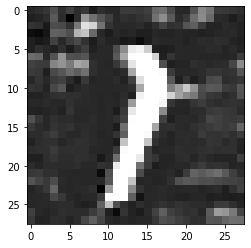

  Min 6.577624369615535
  Max 20.633184433544557
  Avg 8.082541847476868
  Std 2.9506881205206317
-- Generation 26 --
  Min 6.187588403410928
  Max 19.886356259172544
  Avg 7.611537214524062
  Std 2.3633127382954564
-- Generation 27 --
  Min 6.146286669719814
  Max 19.123876779900684
  Avg 7.74764475793246
  Std 2.7050185417080432
-- Generation 28 --
  Min 6.146286669719814
  Max 22.331743816903554
  Avg 7.235762138269336
  Std 2.3659901696594696
-- Generation 29 --
  Min 5.612999015869718
  Max 26.49301117865639
  Avg 7.987003147655107
  Std 3.223143533761616
-- Generation 30 --


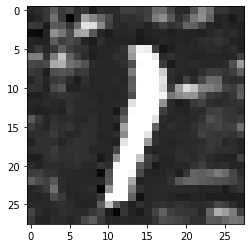

  Min 5.612999015869718
  Max 34.261579734667066
  Avg 7.816379775870166
  Std 4.148413125654475
-- Generation 31 --
  Min 5.612999015869718
  Max 22.731633541780184
  Avg 7.527260700326392
  Std 3.0469639124003045
-- Generation 32 --
  Min 5.5103951006933585
  Max 25.85831652210095
  Avg 7.73141631389456
  Std 4.334703028819445
-- Generation 33 --
  Min 5.5103951006933585
  Max 27.151832156851924
  Avg 7.335025734332976
  Std 4.257791175669882
-- Generation 34 --
  Min 5.5103951006933585
  Max 24.869997671094325
  Avg 7.203304720960261
  Std 4.037163496185895
-- Generation 35 --


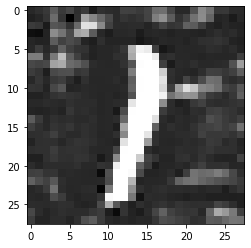

  Min 5.502662066932373
  Max 24.377649025436995
  Avg 6.768894437923581
  Std 3.079801823429684
-- Generation 36 --
  Min 5.490173806502753
  Max 22.48182130945588
  Avg 7.209249533793709
  Std 3.497488582435907
-- Generation 37 --
  Min 5.490173806502753
  Max 20.91936807394177
  Avg 6.8431423642584335
  Std 2.910728949610245
-- Generation 38 --
  Min 5.463541110894084
  Max 24.501558703879937
  Avg 7.048876029567291
  Std 3.4817305577073134
-- Generation 39 --
  Min 5.437027650809853
  Max 34.19368944248072
  Avg 6.8723549763034155
  Std 3.898483447861289
-- Generation 40 --


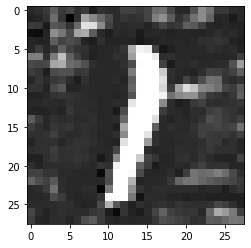

  Min 5.463541110894084
  Max 21.0101543434032
  Avg 6.855094127845116
  Std 3.233564561941535
-- Generation 41 --
  Min 5.463541110894084
  Max 30.949846783642215
  Avg 6.8780005994234985
  Std 3.8918065235466592
-- Generation 42 --
  Min 5.463541110894084
  Max 26.94719867225126
  Avg 6.908403570526546
  Std 3.7886314840814177
-- Generation 43 --
  Min 5.463541110894084
  Max 21.695466928306132
  Avg 6.722190560170352
  Std 3.084983862855773
-- Generation 44 --
  Min 5.463541110894084
  Max 23.401236477206112
  Avg 6.525428139801918
  Std 3.0787764651086884
-- Generation 45 --


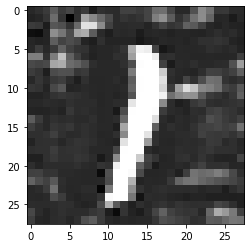

  Min 5.461055903332635
  Max 26.652675503106593
  Avg 6.872683327052019
  Std 4.011621973155301
-- Generation 46 --
  Min 5.461055903332635
  Max 25.069862467899156
  Avg 6.953517436806514
  Std 3.5791631904410988
-- Generation 47 --
  Min 5.461055903332635
  Max 20.899595954400866
  Avg 6.380496648739729
  Std 2.4271635611256097
-- Generation 48 --
  Min 5.461055903332635
  Max 24.03526516502552
  Avg 7.978598741641097
  Std 4.537761789499697
-- Generation 49 --
  Min 5.461055903332635
  Max 18.351797360110368
  Avg 7.050504729488316
  Std 3.378228092753617
-- Generation 50 --


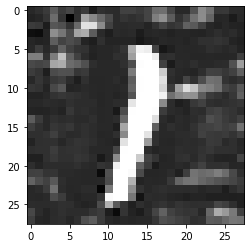

  Min 5.461055903332635
  Max 24.260760803256062
  Avg 7.620292042345973
  Std 4.290215873931099
-- Generation 51 --
  Min 5.4410488868171
  Max 19.91151542925786
  Avg 6.704705178018535
  Std 3.0744941923905733
-- Generation 52 --
  Min 5.4410488868171
  Max 22.882339427551642
  Avg 6.226976097462122
  Std 2.6327390517173326
-- Generation 53 --
  Min 5.441065570925275
  Max 18.752322776210576
  Avg 6.433573163860476
  Std 2.725547864837253
-- Generation 54 --
  Min 5.441065570925275
  Max 22.835826660044404
  Avg 7.57802764469327
  Std 4.077086199481703
-- Generation 55 --


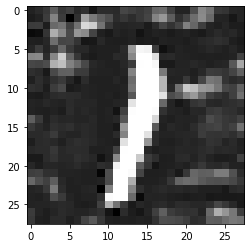

  Min 5.4362193572271735
  Max 20.268110030976686
  Avg 6.894551046921845
  Std 3.165215757200451
-- Generation 56 --
  Min 5.4362193572271735
  Max 25.699738082277918
  Avg 6.957715371024815
  Std 3.8113227347327974
-- Generation 57 --
  Min 5.4362193572271735
  Max 27.95396925685054
  Avg 6.8658130507223385
  Std 3.9054019133957687
-- Generation 58 --
  Min 5.4362193572271735
  Max 25.43211093872378
  Avg 7.285009762136046
  Std 4.53824366545191
-- Generation 59 --
  Min 5.359961576878106
  Max 20.176308562442728
  Avg 6.660226016471936
  Std 3.017298405565747
-- Generation 60 --


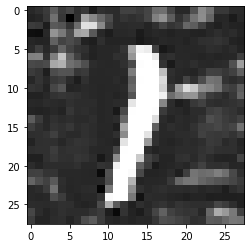

  Min 5.359961576878106
  Max 19.429152370402335
  Avg 6.337129313918265
  Std 2.958332124460157
-- Generation 61 --
  Min 5.359961576878106
  Max 21.391740932713446
  Avg 6.837933937489331
  Std 3.383272547872456
-- Generation 62 --
  Min 5.28885047482396
  Max 23.825669616037203
  Avg 6.773255866223665
  Std 3.438690911263032
-- Generation 63 --
  Min 5.28885047482396
  Max 21.86965078716662
  Avg 6.899854427060457
  Std 3.3871376395448998
-- Generation 64 --
  Min 5.28885047482396
  Max 25.949961673035432
  Avg 6.426755355064033
  Std 2.7801625369304053
-- Generation 65 --


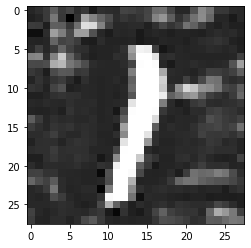

  Min 5.28885047482396
  Max 34.44887149432907
  Avg 6.986910135209823
  Std 4.397707709862484
-- Generation 66 --
  Min 5.28885047482396
  Max 15.223530954449416
  Avg 6.224688471327299
  Std 2.235788284014259
-- Generation 67 --
  Min 5.28885047482396
  Max 18.434731418609772
  Avg 6.49812140296174
  Std 3.0735991259226325
-- Generation 68 --
  Min 5.28885047482396
  Max 16.799607872650313
  Avg 6.124435983261935
  Std 2.1661947911654584
-- Generation 69 --
  Min 5.28885047482396
  Max 29.189604678191245
  Avg 6.507427807925633
  Std 3.5164144641848267
-- Generation 70 --


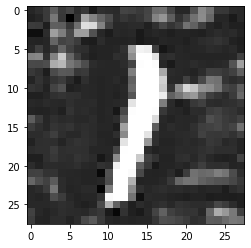

  Min 5.28885047482396
  Max 21.339808163247653
  Avg 6.719634466111768
  Std 3.2901888923888727
-- Generation 71 --
  Min 5.28885047482396
  Max 27.45205592716252
  Avg 6.3828525008215315
  Std 3.4315397971059305
-- Generation 72 --
  Min 5.28885047482396
  Max 33.81622211677518
  Avg 6.773799034336539
  Std 3.8299442119456173
-- Generation 73 --
  Min 5.28885047482396
  Max 20.5323043466351
  Avg 7.077560464348253
  Std 3.558686474597996
-- Generation 74 --
  Min 5.28885047482396
  Max 25.64106453576187
  Avg 6.389390421990511
  Std 2.9767074559439277
-- Generation 75 --


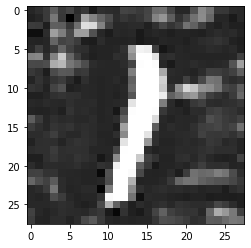

  Min 5.28885047482396
  Max 20.234604901637795
  Avg 6.208158986437574
  Std 2.7754066319980004
-- Generation 76 --
  Min 5.28885047482396
  Max 17.387616146516166
  Avg 6.670437896768524
  Std 2.833793946186972
-- Generation 77 --
  Min 5.28885047482396
  Max 20.33588293230082
  Avg 6.197344206517809
  Std 2.707765530492101
-- Generation 78 --
  Min 5.28885047482396
  Max 20.53538125949217
  Avg 6.666887614738807
  Std 3.2131739419648286
-- Generation 79 --
  Min 5.28885047482396
  Max 16.998807772910368
  Avg 6.169319003090595
  Std 2.4387240658396467
-- Generation 80 --


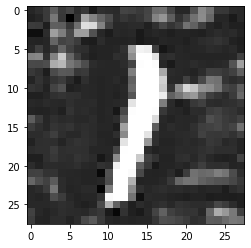

  Min 5.28885047482396
  Max 20.889290599385276
  Avg 6.512868632866107
  Std 3.1467015137130603
-- Generation 81 --
  Min 5.28885047482396
  Max 20.352594293308357
  Avg 6.134032154175352
  Std 2.769663429124631
-- Generation 82 --
  Min 5.28885047482396
  Max 20.532701912293305
  Avg 6.536169644259039
  Std 2.912775177311583
-- Generation 83 --
  Min 5.28885047482396
  Max 27.6211406427401
  Avg 6.236882315504602
  Std 3.0916030233389105
-- Generation 84 --
  Min 5.28885047482396
  Max 24.5258427493618
  Avg 6.835291952491377
  Std 3.898168034107653
-- Generation 85 --


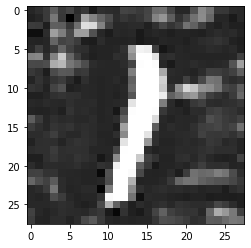

  Min 5.28885047482396
  Max 20.587706740684553
  Avg 6.823002726915668
  Std 3.334485203844105
-- Generation 86 --
  Min 5.28885047482396
  Max 19.806682960130274
  Avg 6.725674484101376
  Std 3.3534039163130003
-- Generation 87 --
  Min 5.28885047482396
  Max 22.444802636513487
  Avg 6.754238878914355
  Std 3.4795845539930785
-- Generation 88 --
  Min 5.28885047482396
  Max 16.641341473223292
  Avg 6.441244399472039
  Std 2.829739097860579
-- Generation 89 --
  Min 5.28885047482396
  Max 26.365103081990128
  Avg 6.568310171004566
  Std 3.4365860151343925
-- Generation 90 --


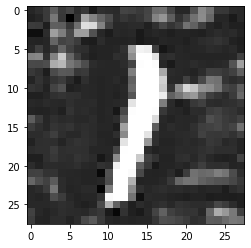

  Min 5.28885047482396
  Max 19.547138367143134
  Avg 6.51509162205826
  Std 2.8781602454283766
-- Generation 91 --
  Min 5.28885047482396
  Max 20.49821445409998
  Avg 6.402592289608935
  Std 2.75913466241088
-- Generation 92 --
  Min 5.28885047482396
  Max 19.69132161149537
  Avg 6.480410947023511
  Std 3.0195130107817643
-- Generation 93 --
  Min 5.28885047482396
  Max 25.80447592850419
  Avg 6.929574932466403
  Std 3.6696846067595734
-- Generation 94 --
  Min 5.28885047482396
  Max 22.202291409763575
  Avg 6.654618967791334
  Std 3.3488479491583165
-- Generation 95 --


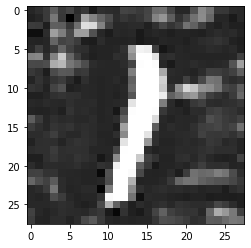

  Min 5.28885047482396
  Max 21.688173676017186
  Avg 6.884551360889488
  Std 3.438382910776933
-- Generation 96 --
  Min 5.28885047482396
  Max 24.462850944928505
  Avg 6.44611642294411
  Std 3.200600004386881
-- Generation 97 --
  Min 5.28885047482396
  Max 29.762002970583353
  Avg 6.73559097021976
  Std 3.715841000677194
-- Generation 98 --
  Min 5.28885047482396
  Max 25.103380045658014
  Avg 6.911851951759684
  Std 3.9566046515695166
-- Generation 99 --
  Min 5.201495556525515
  Max 21.618514378170403
  Avg 6.4788885329715455
  Std 2.6687082397206017
-- Generation 100 --


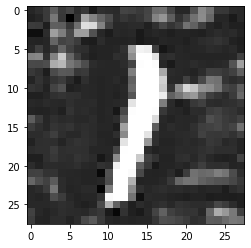

  Min 5.28885047482396
  Max 21.221482278910116
  Avg 6.558983549127895
  Std 3.3539120686039263
-- End of (successful) evolution --
Best individual is [ 1.75088122e-01 -4.24670149e-03  0.00000000e+00  7.04087555e-01
  9.79174525e-02  0.00000000e+00  0.00000000e+00 -1.64310217e+00
 -5.80406785e-01 -4.31770712e-01  1.12399936e-01 -6.28464580e-01
 -1.27959681e+00 -1.65024832e-01 -6.17733002e-02  1.30795050e+00
  0.00000000e+00  0.00000000e+00 -2.39908829e-01 -6.58111870e-01
 -8.07974398e-01 -1.39531124e+00 -3.32943618e-01  4.10491019e-01
 -5.74169993e-01  1.15092337e-01  0.00000000e+00  1.78851143e-01
 -5.26339710e-01 -3.58427584e-01 -3.11843485e-01  1.19862688e+00
  1.15116692e+00  0.00000000e+00  6.78237736e-01  1.07179344e+00
 -1.91765153e+00  0.00000000e+00  1.23833406e+00  1.34013247e+00
  8.58000338e-01  9.79441524e-01  9.46560144e-01  0.00000000e+00
  0.00000000e+00 -5.56584239e-01  8.41866073e-04 -5.56096375e-01
  4.93879467e-01  9.89293337e-01  8.01043510e-01 -1.27786085e-01
 -6

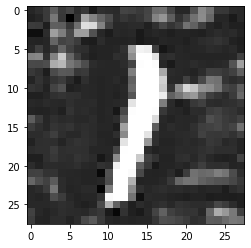

In [10]:
# For each generation, select the latent vector z* that minimizes fitness, and do the following.
# z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)  # torch.Size([100, 1, 1]). This should be z* later on.
output = np.array(main())

z = torch.from_numpy(output).view(1, 100, 1, 1)

gen_image = netG(z)  # torch.Size([1, 28, 28]). This is the generated image that we want to see for each generation.
# Because gen_image should step closer to fgsm_image x for each generation.
print("the shape of generated image : " + str(gen_image.shape))
imshow(gen_image.detach())  # plot the image of generated image

# After GA, give generated image as input to each classifier (use gen_image)